# Reproducing RepLiQA evaluations using openrouter.ai

In [ ]:
import os
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import openai_client
from src.hs import HSBaseline
from src.qa import QAEvaluator
from src.judges import JUDGES

/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Get repliqa and its set of topics
Here we're only using the `repliqa_0` split.

In [2]:
dataset_name = f"repliqa_0"
repliqa = datasets.load_dataset("ServiceNow/repliqa")[dataset_name]
topics = list(set(repliqa["document_topic"]))
assert len(topics) == 17
topics, len(repliqa)

(['Local Technology and Innovation',
  'Local Environmental Issues',
  'Local Arts and Culture',
  'News Stories',
  'Local Sports and Activities',
  'Cybersecurity News',
  'Regional Folklore and Myths',
  'Local Health and Wellness',
  'Regional Cuisine and Recipes',
  'Company Policies',
  'Local News',
  'Small and Medium Enterprises',
  'Local Politics and Governance',
  'Neighborhood Stories',
  'Incident Report',
  'Local Economy and Market',
  'Local Education Systems'],
 17955)

## Highlight&Summarize

In [12]:
hs = HSBaseline(
    model_name="gpt-4.1-mini",
    openai_client=openai_client,
    temperature=0.3,
    n_trials=1,
    sleep_time_between_retrials=1.0,
    max_sleep_time_between_retrials=600.0,
)
hs(repliqa[1]), repliqa[1]["question"]

calling


({'answer_pred': 'Zhao is committed to maintaining work-life balance by disconnecting from work communications after hours and valuing personal time for family, reading, and relaxation. He encourages his staff to take ample time off for rest and personal activities, believing that well-rounded lives lead to satisfied employees and successful businesses.',
  'model_name': 'gpt-4.1-mini',
  'temperature': 0.3,
  'raw_response': None,
  'guessed_question': 'How does Zhao approach work-life balance for himself and his staff?',
  'raw_text_extracts': ['"Zhao recognizes the demands of WeTech can be overwhelming, yet is committed to maintaining work-life equilibrium. At the end of each workday he remains firm in his commitment to disconnecting from all work-related communication after leaving work for good."',
   '"\\"Time spent with family, reading or taking a quiet stroll through the park can be just as beneficial to my work life as time spent at my desk,\\" Zhao noted. It is during these q

## LLM as a Judge

In [17]:
judge = QAJudge(model_name="gpt-4.1-mini", openai_client=openai_client)
print(judge._call_judge(
    judge_name="MT-bench-QA",
    input="What motivated Zhao Wei to found WeTech?",
    output="Beer",
    expected="Zhao was motivated by his belief in doing well by doing good."
))
print(judge._call_judge(
    judge_name="MT-bench-QA",
    input="What motivated Zhao Wei to found WeTech?",
    output="UNANSWERABLE",
    expected="The answer is not found in the document."
))
print(judge._call_judge(
    judge_name="MT-bench-QA",
    input="What motivated Zhao Wei to found WeTech?",
    output="Wrong answer",
    expected="The answer is not found in the document."
))

{'rating': 1, 'raw_response': 'The response provided, "Beer," is completely irrelevant and unhelpful in addressing the user\'s question about Zhao Wei\'s motivation to found WeTech. It lacks any accuracy, depth, or detail, and fails to demonstrate understanding of the topic. As a result, it does not meet any of the criteria for a quality response.'}
{'rating': 10, 'raw_response': 'Unanswerable question.'}
{'rating': 1, 'raw_response': 'Unanswerable question.'}


## Evaluation

### Run all models

What should we evaluate:

In [ ]:
RESULTS_DIR = "results"
PIPELINES = [
    {
        "pipeline": QAEvaluator,
        "model_name": "gpt-4.1-mini",
        "temperature": 0.3,
    },
    {
        "pipeline": QAEvaluator,
        "model_name": "gpt-4o",
        "temperature": 0.3,
    },
    {
        "pipeline": HSBaseline,
        "model_name": "gpt-4.1-mini",
        "temperature": 0.3,
    },
]
N_TRIALS = 5
# Data.
from datasets import concatenate_datasets
N = 30
DATASET = repliqa.select(range(N))
DATASET = concatenate_datasets([
    DATASET,
    repliqa.filter(lambda example: example["answer"] == "The answer is not found in the document.").select(range(30))
])
print(f"Dataset size: {N}")
print(f"Number of unanswerable questions: {len(DATASET)-N}")

Loading cached processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-b32869685266d5c0.arrow


Set __getitem__(key) output type to python objects for ['document_id', 'document_topic', 'document_path', 'document_extracted', 'question_id', 'question', 'answer', 'long_answer'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True
Dataset size: 30
Number of unanswerable questions: 30


**Load from previous runs**

Data is stored in `RESULTS_DIR`, within directories
named as `{pipeline}-{model_name}`, e.g.: `HSBaseline-gpt-4.1-mini`.

In [48]:
inference_datasets = {}
os.makedirs(RESULTS_DIR, exist_ok=True)
for dir in os.listdir(RESULTS_DIR):
    if not os.path.isdir(os.path.join(RESULTS_DIR, dir)):
        continue
    inference_datasets[dir] = datasets.load_from_disk(os.path.join(RESULTS_DIR, dir))

print(f"Loaded: {list(inference_datasets.keys())}")

Set __getitem__(key) output type to python objects for ['MT-bench-QA_rating', 'MT-bench-QA_raw_response', 'answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.
Set __getitem__(key) output type to python objects for ['MT-bench-QA_rating', 'MT-bench-QA_raw_response', 'answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loaded: ['QAEvaluator-gpt-4.1-mini', 'QAEvaluator-gpt-4o']


**Do it**

In [49]:
for pipeline in PIPELINES:
    model_name = pipeline["model_name"]
    rag_pipeline = pipeline["pipeline"]
    temperature = pipeline["temperature"]
    run_id = f"{rag_pipeline.__name__}-{model_name}"

    print(model_name)
    # Question answering.
    if run_id in inference_datasets and "answer_pred" in inference_datasets[run_id].column_names:
        print(f"Skipping predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        prediction_dataset = inference_datasets[run_id]
    else:
        pipeline = rag_pipeline(
            model_name=model_name,
            openai_client=openai_client,
            temperature=temperature,
            n_trials=N_TRIALS,
        )
        prediction_dataset = DATASET.map(
            pipeline,
            desc=f"Generating predictions",
            num_proc=1,
            )
        # Store.
        print(f"Storing predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        prediction_dataset.save_to_disk(os.path.join(RESULTS_DIR, run_id))

    # Judging.
    if "MT-bench-QA_rating" in prediction_dataset.column_names:
        print(f"Skipping judging for: {model_name} with {rag_pipeline.__name__} pipeline.")
    else:
        prediction_dataset = prediction_dataset.map(
            judge,
            desc=f"Judging predictions",
            num_proc=1
        )
        # Store.
        print(f"Storing judged predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        prediction_dataset.save_to_disk(os.path.join(RESULTS_DIR, run_id))
    
    inference_datasets[run_id] = prediction_dataset

/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.SummarizerOutput'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.SummarizerOutput'>: __main__.SummarizerOutput has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


gpt-4.1-mini
Skipping predictions for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping judging for: gpt-4.1-mini with QAEvaluator pipeline.
gpt-4o
Skipping predictions for: gpt-4o with QAEvaluator pipeline.
Skipping judging for: gpt-4o with QAEvaluator pipeline.
gpt-4.1-mini
Loading: True


Generating predictions:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


calling


Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-6e7c6bfdcfa5a1b4.arrow
Generating predictions:   2%|▏         | 1/60 [00:02<02:46,  2.83s/ examples]

calling


Generating predictions:   3%|▎         | 2/60 [00:06<03:06,  3.22s/ examples]

calling


Generating predictions:   5%|▌         | 3/60 [00:08<02:48,  2.96s/ examples]

calling


Generating predictions:   7%|▋         | 4/60 [00:12<02:56,  3.14s/ examples]

calling


Generating predictions:   8%|▊         | 5/60 [00:15<02:43,  2.97s/ examples]

calling


Generating predictions:  10%|█         | 6/60 [00:17<02:26,  2.71s/ examples]

calling


Generating predictions:  12%|█▏        | 7/60 [00:20<02:38,  3.00s/ examples]

calling


Generating predictions:  13%|█▎        | 8/60 [00:23<02:28,  2.86s/ examples]

calling


Generating predictions:  15%|█▌        | 9/60 [00:25<02:16,  2.67s/ examples]

calling


Generating predictions:  17%|█▋        | 10/60 [00:27<02:05,  2.50s/ examples]

calling


Generating predictions:  18%|█▊        | 11/60 [00:30<02:02,  2.49s/ examples]

calling


Generating predictions:  20%|██        | 12/60 [00:32<01:59,  2.48s/ examples]

calling


Generating predictions:  22%|██▏       | 13/60 [00:35<02:06,  2.69s/ examples]

calling


Generating predictions:  23%|██▎       | 14/60 [00:38<01:57,  2.56s/ examples]

calling


Generating predictions:  25%|██▌       | 15/60 [00:40<01:53,  2.53s/ examples]

calling


Generating predictions:  27%|██▋       | 16/60 [00:42<01:43,  2.35s/ examples]

calling


Generating predictions:  28%|██▊       | 17/60 [00:45<01:42,  2.39s/ examples]

calling


Generating predictions:  30%|███       | 18/60 [00:47<01:43,  2.47s/ examples]

calling


Generating predictions:  32%|███▏      | 19/60 [00:50<01:44,  2.56s/ examples]

calling


Generating predictions:  33%|███▎      | 20/60 [00:53<01:47,  2.69s/ examples]

calling


Generating predictions:  35%|███▌      | 21/60 [00:56<01:45,  2.70s/ examples]

calling


Generating predictions:  37%|███▋      | 22/60 [00:58<01:38,  2.60s/ examples]

calling


Generating predictions:  38%|███▊      | 23/60 [01:00<01:28,  2.40s/ examples]

calling


Generating predictions:  40%|████      | 24/60 [01:03<01:28,  2.45s/ examples]

calling


Generating predictions:  42%|████▏     | 25/60 [01:05<01:25,  2.45s/ examples]

calling


Generating predictions:  43%|████▎     | 26/60 [01:07<01:20,  2.36s/ examples]

calling


Generating predictions:  45%|████▌     | 27/60 [01:10<01:23,  2.54s/ examples]

calling


Generating predictions:  47%|████▋     | 28/60 [01:14<01:33,  2.92s/ examples]

calling


Generating predictions:  48%|████▊     | 29/60 [01:17<01:28,  2.87s/ examples]

calling


Generating predictions:  50%|█████     | 30/60 [01:19<01:20,  2.69s/ examples]

calling


Generating predictions:  52%|█████▏    | 31/60 [01:20<01:03,  2.18s/ examples]

Score: 14.28571428571429
Text extract not found in context: "UNANSWERABLE"
Context: Expanding Horizons: The Rise of Adult Education at Community Colleges 

In recent years, community colleges have experienced a remarkable surge in the enrollment of adult learners seeking to enrich their lives and careers. Gone are the days when higher education was confined to those fresh out of high school. Today, we are witnessing a diverse group of adult students, ranging from mid-career professionals to retirees, flocking into community college classrooms. On a brisk autumn morning, October 15, 2023, I visited the bustling campus of Meadow Valley Community College (MVCC), a forerunner in the adult education landscape. What I discovered was both inspiring and indicative of a pivotal shift in educational priorities. 

Meeting a Community's Evolving Educational Needs 

MVCC's Adult Learning Center bustles with activity as individuals from various walks of life immerse themselves in everything from bas

Generating predictions:  53%|█████▎    | 32/60 [01:24<01:13,  2.63s/ examples]

calling


Generating predictions:  55%|█████▌    | 33/60 [01:26<01:10,  2.61s/ examples]

calling
Score: 90.63670411985018
Text extract not found in context: Evelyn Richards, a teacher who participated in the professional development series, shared, "This training has transformed my approach to teaching. I'm now able to design lessons that not only cover multiple subject areas but also engage students in deeper learning."
Context: ## Innovative Teaching Methodologies in Modern Classrooms: Embracing CrossDisciplinary Approaches ## 

The educational landscape is constantly evolving, with innovative teaching methodologies emerging as the cornerstone of modern classrooms. As educators and policymakers alike seek to enhance learning experiences and outcomes, cross-disciplinary approaches are gaining prominence. These methodologies not only break the monotonous barriers of subject-specific learning but also encourage a holistic development in students, preparing them for real-world challenges. Here, we delve into the pioneering strategies that are redefining teaching and how scho

Generating predictions:  57%|█████▋    | 34/60 [01:32<01:36,  3.71s/ examples]

calling


Generating predictions:  58%|█████▊    | 35/60 [01:36<01:31,  3.64s/ examples]

calling


Generating predictions:  60%|██████    | 36/60 [01:37<01:06,  2.78s/ examples]

Unexpected response format: UNANSWERABLE
calling


Generating predictions:  62%|██████▏   | 37/60 [01:40<01:06,  2.89s/ examples]

calling


Generating predictions:  63%|██████▎   | 38/60 [01:42<01:02,  2.82s/ examples]

calling


Generating predictions:  65%|██████▌   | 39/60 [01:43<00:46,  2.23s/ examples]

Unexpected response format: UNANSWERABLE
calling


Generating predictions:  67%|██████▋   | 40/60 [01:47<00:52,  2.62s/ examples]

calling


Generating predictions:  68%|██████▊   | 41/60 [01:48<00:39,  2.10s/ examples]

Unexpected response format: UNANSWERABLE
calling


Generating predictions:  70%|███████   | 42/60 [01:51<00:42,  2.35s/ examples]

calling


Generating predictions:  72%|███████▏  | 43/60 [01:54<00:43,  2.56s/ examples]

calling


Generating predictions:  73%|███████▎  | 44/60 [01:56<00:40,  2.51s/ examples]

calling


Generating predictions:  75%|███████▌  | 45/60 [01:59<00:40,  2.68s/ examples]

calling


Generating predictions:  77%|███████▋  | 46/60 [02:03<00:43,  3.09s/ examples]

calling


Generating predictions:  78%|███████▊  | 47/60 [02:06<00:40,  3.09s/ examples]

calling


Generating predictions:  80%|████████  | 48/60 [02:09<00:35,  2.92s/ examples]

calling


Generating predictions:  82%|████████▏ | 49/60 [02:12<00:33,  3.03s/ examples]

calling


Generating predictions:  83%|████████▎ | 50/60 [02:18<00:37,  3.74s/ examples]

calling


Generating predictions:  85%|████████▌ | 51/60 [02:21<00:33,  3.70s/ examples]

calling


Generating predictions:  87%|████████▋ | 52/60 [02:22<00:22,  2.84s/ examples]

Unexpected response format: UNANSWERABLE
calling


Generating predictions:  88%|████████▊ | 53/60 [02:23<00:15,  2.26s/ examples]

Score: 16.666666666666664
Text extract not found in context: UNANSWERABLE
Context: Collaboration and Partnerships: Leveraging Community Resources in Learning Centers 

In today's fast-paced educational climate, community learning centers (CLCs) offer a beacon of hope for communities seeking more inclusive and effective strategies to enhance learning and personal development. At the heart of their success lies an untapped potential – the power of collaboration and partnership. As local education systems evolve, CLCs have begun to harness this potential, recognizing that the sum of collective efforts far exceeds individual endeavors. 

The Advent of Community Learning Centers 

Post September 1, 2023, there's been a pronounced shift in how communities approach education. No longer solely the domain of public schools, education now extends into the realm of community-based facilities that offer enrichment programs for all ages. The concept of Community Learning Centers sprang up as a resp

Generating predictions:  90%|█████████ | 54/60 [02:26<00:14,  2.48s/ examples]

calling


Generating predictions:  92%|█████████▏| 55/60 [02:27<00:10,  2.04s/ examples]

Score: 16.666666666666664
Text extract not found in context: UNANSWERABLE
Context: The Growing Importance of Soft Skills in the Workplace 

In today's fast-evolving job market, there has been an increased emphasis on the value of soft skills across various industries. While technical expertise and hard skills continue to be the bedrock of employee qualifications, the nuanced, often intangible qualities associated with soft skills are becoming equally critical for success. Since September 1, 2023, there has been a consistent rise in discussions around soft skills, led by HR professionals, career experts, and industry leaders. 

Soft Skills 101: What You Need to Thrive in Today's Job Market 

To grasp the essence of this shift, it's essential to define what soft skills entail. Unlike hard skills – which are job-specific and measurable, like coding languages or the ability to operate machinery – soft skills are interpersonal and more challenging to quantify. Key soft skills include commun

Generating predictions:  93%|█████████▎| 56/60 [02:31<00:11,  2.80s/ examples]

calling


Generating predictions:  95%|█████████▌| 57/60 [02:34<00:07,  2.61s/ examples]

calling


Generating predictions:  97%|█████████▋| 58/60 [02:36<00:05,  2.54s/ examples]

calling


Generating predictions:  98%|█████████▊| 59/60 [02:39<00:02,  2.61s/ examples]

calling


Generating predictions: 100%|██████████| 60/60 [02:40<00:00,  2.67s/ examples]
Set __getitem__(key) output type to python objects for ['answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'guessed_question', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'raw_text_extracts', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Unexpected response format: UNANSWERABLE
Storing predictions for: gpt-4.1-mini with HSBaseline pipeline.


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to python objects for ['answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'guessed_question', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'raw_text_extracts', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.
Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Saving the dataset (1/1 shards): 100%|██████████| 60/60 [00:00<00:00, 1976.95 examples/s]
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.QAJudgeResponse'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:41

Loading: True


Judging predictions:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-4c2e362b4b06c821.arrow
Judging predictions: 100%|██████████| 60/60 [00:49<00:00,  1.22 examples/s]
Set __getitem__(key) output type to python objects for ['MT-bench-QA_rating', 'MT-bench-QA_raw_response', 'answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'guessed_question', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'raw_text_extracts', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Storing judged predictions for: gpt-4.1-mini with HSBaseline pipeline.


Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to python objects for ['MT-bench-QA_rating', 'MT-bench-QA_raw_response', 'answer', 'answer_pred', 'document_extracted', 'document_id', 'document_path', 'document_topic', 'guessed_question', 'long_answer', 'model_name', 'question', 'question_id', 'raw_response', 'raw_text_extracts', 'temperature'] columns  (when key is int or slice) and don't output other (un-formatted) columns.
Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Saving the dataset (1/1 shards): 100%|██████████| 60/60 [00:00<00:00, 739.10 examples/s]


**Store to Excel for manual inspection**

In [42]:
import pandas as pd
select = ["question", "answer", "answer_pred", "model_name", "temperature", "MT-bench-QA_rating", "MT-bench-QA_raw_response"]
to_cat = []

for model_name, dataset in inference_datasets.items():
    to_cat.append(pd.DataFrame(dataset)[select])
    to_cat[-1]["pipeline"] = model_name.split("-")[0]
    if "raw_text_extracts" in dataset.column_names:
        to_cat[-1]["raw_text_extracts"] = dataset["raw_text_extracts"]
    else:
        to_cat[-1]["raw_text_extracts"] = None

df = pd.concat(to_cat, ignore_index=True)
df.to_excel(
    os.path.join(RESULTS_DIR, "repliqa_results.xlsx"),
    index=False,
    engine="openpyxl"
)

#### Data analysis

**Scores on answerable questions**

In [44]:
ratings = {}
for model_name in inference_datasets:
    dataset = inference_datasets[model_name].filter(
        lambda example: example["answer"] != "The answer is not found in the document."
    )
    # For all judges.
    for col in dataset.column_names:
        if col.endswith("_rating"):
            ratings.setdefault(model_name, {})[col] = dataset[col]

Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-6a798ed9e3702c67.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 1042.47 examples/s]


Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-041dfca1bb562e72.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 1037.50 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-bdeabb48fba773ed.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 1410.21 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


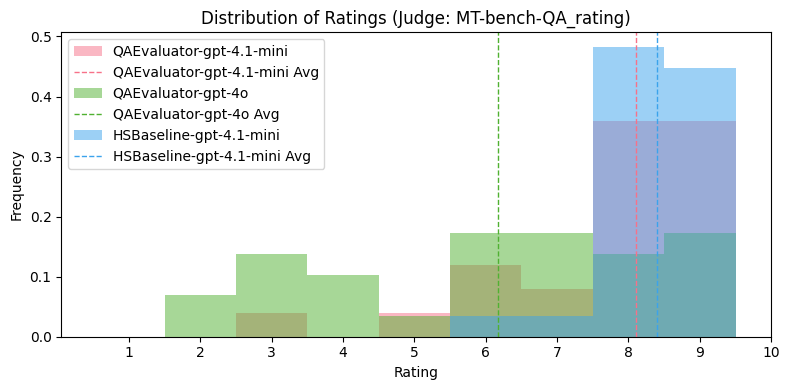

In [45]:
judge_names = list(ratings[next(iter(ratings))].keys())

for judge_name in judge_names:
    plt.figure(figsize=(8, 4))
    colors = sns.color_palette("husl", len(ratings))
    for model_name, model_ratings in ratings.items():
        color = colors.pop(0)
        judge_ratings = model_ratings[judge_name]
        plt.hist(judge_ratings, bins=np.arange(1, 11) - 0.5, alpha=0.5, label=f"{model_name}", color=color, density=True)
        # A vertical line for each model's average rating.
        avg_rating = np.mean(judge_ratings)
        plt.axvline(avg_rating, linestyle='--', linewidth=1, label=f"{model_name} Avg", color=color)

    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Ratings (Judge: {judge_name})")
    plt.xticks(np.arange(1, 11))
    plt.legend()
    plt.tight_layout()

**Score on unanswerable questions**

In [46]:
scores = {}
for model_name in inference_datasets:
    dataset = inference_datasets[model_name].filter(
        lambda example: example["answer"] == "The answer is not found in the document."
    )
    scores[model_name] = len(dataset.filter(
        lambda example: example["answer_pred"] == "UNANSWERABLE"
    )) / len(dataset) * 100

scores

Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-15f3354ef7a27044.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 1623.86 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/30 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-8fc0286388d46c3d.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 30/30 [00:00<00:00, 1057.97 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-1182387858240b4b.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 2486.15 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/30 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-8ec6b24c84084266.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 30/30 [00:00<00:00, 1039.29 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/60 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-74eb2fdbdc31cbe6.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 60/60 [00:00<00:00, 2266.82 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


Loading: True


Filter:   0%|          | 0/30 [00:00<?, ? examples/s]Set __getitem__(key) output type to arrow for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Caching processed dataset at /home/gcherubin/.cache/huggingface/datasets/ServiceNow___repliqa/default/0.0.0/ab75faf05430b794bd5c1006c46215ad20f822a5/cache-8d367fe4f987834c.arrow
Finished processing shard number None of 1.
Filter: 100%|██████████| 30/30 [00:00<00:00, 574.29 examples/s]
Set __getitem__(key) output type to python objects for ['indices'] columns  (when key is int or slice) and don't output other (un-formatted) columns.


{'QAEvaluator-gpt-4.1-mini': 36.666666666666664,
 'QAEvaluator-gpt-4o': 60.0,
 'HSBaseline-gpt-4.1-mini': 26.666666666666668}

In [78]:
import pandas as pd
pd.DataFrame(dataset)[["question", "answer", "answer_pred", "MT-bench-QA_raw_response"]]

,question,answer,answer_pred,MT-bench-QA_raw_response
0,What motivated Zhao Wei to found WeTech?,Zhao was motivated by his belief in doing well...,Zhao Wei was motivated to found WeTech by his ...,The assistant's response accurately captures Z...
1,How does Zhao Wei ensure a work-life balance a...,Zhao commits to disconnecting from work-relate...,Zhao Wei maintains work-life balance by discon...,The assistant's response is accurate and relev...
2,How has WeTech involved itself in the local co...,"WeTech sponsors local youth coding programs, p...","WeTech sponsors local youth coding programs, p...",The assistant's response is accurate and direc...
3,What challenges did Zhao Wei overcome during t...,"Zhao faced limited capital, skepticism from in...","Zhao Wei overcame limited capital resources, s...",The assistant's response is accurate and relev...
4,"What are Zhao Wei's goals for WeTech's future,...",Zhao and WeTech aim to expand product offering...,Zhao Wei's goals for WeTech's future are to ex...,The assistant's response directly and accurate...
...,...,...,...,...
995,What did Professor Archibald McFussyPants of t...,He claimed to have discovered the archetype of...,"The ""archetype of the modern-day hero"" in an a...",The response provided is very brief and somewh...
996,Who suggested that trickster tales were the or...,"Dr. Sasha Smartypants suggested it, giving exa...",Dr. Sasha Smartypants suggested that trickster...,The assistant's response directly answers the ...
997,How do legendary narratives shape societal val...,The answer is not found in the document.,Legendary narratives shape societal values by ...,The response effectively explains how legendar...
998,Can modern society truly relate to heroic arch...,The answer is not found in the document.,"Yes, modern society relates to heroic archetyp...",The assistant's response is somewhat relevant ...


# Unused

In [ ]:
# def evaluate_model(model_name: str, rag_pipeline: QAEvaluator | QAJudge, dataset: datasets.Dataset,
#                    temperature: float = 0.3, n_trials: int = 5) -> datasets.Dataset:
#     """
#     Evaluates a model on a dataset using the provided RAG pipeline.
#     """
#     print(f"Evaluating model: {model_name}")
#     pipeline = rag_pipeline(
#         model_name=model_name,
#         openai_client=openai_client,
#         temperature=temperature,
#         n_trials=n_trials,
#     )
#     prediction_dataset = dataset.map(
#         pipeline,
#         desc=f"Generating predictions",
#         num_proc=1,
#         # cache_file_name=os.path.join(
#         #     "predictions",
#         #     f"{model_name}_predictions_{rag_pipeline}.cache"
#         # ),
#         load_from_cache_file=True,
#         # remove_columns=['document_id', 'document_topic', 'document_path', 'document_extracted', 'question_id', 'long_answer']
#         )
#     prediction_dataset = prediction_dataset.map(judge, desc=f"Judging predictions", num_proc=1)
#     return prediction_dataset

In [66]:
inference_datasets = {}
N_RETRIALS = 5  # Maximum number of re-attempts after failed inference requests

for model in models:
    print(f"Processing model: {model}")
    qa_pre_processor = QAEvaluator(
      model_name=model,
      openai_client=openai_client,
      temperature=0.2,
      n_trials=N_RETRIALS,
    )
    prediction_dataset = repliqa.map(qa_pre_processor)
    prediction_dataset = prediction_dataset.map(
        judge, desc="Judging answers"
    )
    inference_datasets[model] = prediction_dataset

Processing model: gpt-4o


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map: 100%|██████████| 5/5 [00:03<00:00,  1.27 examples/s]
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.QAJudgeResponse'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.QAJudgeResponse'>: __main__.QAJudgeResponse has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Judging answers: 100%|██████████| 5/5 [00:13<00:00,  2.74s/ examples]


In [ ]:
import litellm
import instructor
client = instructor.from_litellm(litellm.completion)
client.chat.completions.create(
            model=JUDGE_LLM_NAME,
            max_tokens=1000,
            temperature=0.1,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that evaluates the correctness of answers to questions based on provided contexts.",
                },
                {
                    "role": "user",
                    "content": "Evaluate the correctness of the following answer based on the context provided. "
                               "If the answer is correct, output 'CORRECT'. If it is incorrect, output 'INCORRECT'. "
                               "Context: 'The capital of France is Paris.' Answer: 'Paris is the capital of France.'",
                },
            ],
            response_format={"type": "json_object"}
        )